In [1]:
# Bi-directional LSTM
    # Vector Embedding layer (each work = n-dimensional vector)
    # Bi-directional LSTM with return_sequence True -> another Bi-directional LSTM
    # Dense layer with multiclass o/p
# General approach: 
    # Tweets: Sentences -> tokenize -> pad/truncate
    # Labels: label encoding

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib  inline

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nlp
import random

In [3]:
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


### Data Load

In [4]:
df = nlp.load_dataset('emotion')

Using custom data configuration default


In [5]:
df

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train = df['train']
val = df['validation']
test = df['test']

In [7]:
def get_tweet(data):
    tweets = [row['text'] for row in data]
    labels = [row['label'] for row in data]
    return tweets, labels

In [8]:
train_tweets, train_labels = get_tweet(train)

In [9]:
len(train_tweets)

16000

In [10]:
train_tweets[0:2], train_labels[0:2]

(['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 ['sadness', 'sadness'])

### Tokenize the tweets

In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

In [12]:
tokenizer.fit_on_texts(train_tweets)

In [13]:
tokenizer.texts_to_sequences([train_tweets[0]]), train_tweets[0]

([[2, 139, 3, 679]], 'i didnt feel humiliated')

### Padding & Truncating tweets - model will need a fixed shape

In [14]:
lengths = [len(t.split(' ')) for t in train_tweets]

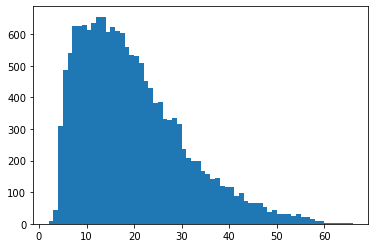

In [15]:
plt.hist(lengths, bins=len(set(lengths)));

In [16]:
maxlen = 50

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [17]:
train_padded_seq = get_sequences(tokenizer, train_tweets)

In [18]:
train_padded_seq.shape

(16000, 50)

In [19]:
train_padded_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [20]:
train_tweets[0]

'i didnt feel humiliated'

In [21]:
train_padded_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [22]:
train_tweets[1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

### Preparing Labels - text class to index

In [23]:
train_labels[0:5]

['sadness', 'sadness', 'anger', 'love', 'anger']

In [24]:
set(train_labels)

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

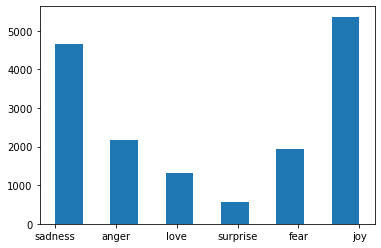

In [25]:
plt.hist(train_labels, bins=11);

In [26]:
class_to_index = dict((emo, i) for i, emo in enumerate(set(train_labels)))
print(class_to_index)

index_to_class = dict((i, emo) for emo, i in class_to_index.items())
print(index_to_class)

{'fear': 0, 'love': 1, 'joy': 2, 'surprise': 3, 'sadness': 4, 'anger': 5}
{0: 'fear', 1: 'love', 2: 'joy', 3: 'surprise', 4: 'sadness', 5: 'anger'}


In [27]:
train_labels_class = np.array([class_to_index[x] for x in train_labels])

In [28]:
train_labels_class[0:5], train_labels[0:5]

(array([4, 4, 5, 1, 5]), ['sadness', 'sadness', 'anger', 'love', 'anger'])

### TensorFlow Model Setup

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),     # output will be 50 vectors of 16 dimensions each
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)), # Bidirectional wrapper for LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [30]:
# Embedding Layer - turns positive integers (indexes) into dense vectors of fixed size.
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
    # input_dim: size of the vocabulary in the text data
    # output_dim: size of the vector space in which words will be embedded
    # input_length: length of input sequences
    # The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words
    
# Bidirectional Layer
# https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
    # Bidirectional LSTMs train two LSTMs on the input sequence - first on as-is and second on a reversed copy
    # return_sequences - every time-step there will be an output

In [31]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


### Model Training

#### Prepping Validation dataset

In [33]:
def prep_data(df):
    df_tweets, df_labels = get_tweet(df)
    df_padded_seq = get_sequences(tokenizer, df_tweets)
    df_labels_class = np.array([class_to_index[x] for x in df_labels])
    return df_padded_seq, df_labels_class

In [34]:
val_padded_seq, val_labels_class = prep_data(val)

In [35]:
print(val[0])

print(val_padded_seq[0],'\n', val_labels_class[0])

{'label': 'sadness', 'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon'}
[ 17   8 157 260   4 343  16  51  19 212   1  50  10  13 533   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0] 
 4


#### Training Model

In [36]:
h = model.fit(train_padded_seq, train_labels_class,
              validation_data=(val_padded_seq, val_labels_class),
              epochs=20, 
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
             )

Epoch 1/20
500/500 [==============================] - 13s 17ms/step - loss: 1.3418 - accuracy: 0.4596 - val_loss: 0.8807 - val_accuracy: 0.6835
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.6742 - accuracy: 0.7441 - val_loss: 0.6099 - val_accuracy: 0.7930
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3707 - accuracy: 0.8732 - val_loss: 0.4941 - val_accuracy: 0.8425
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2300 - accuracy: 0.9251 - val_loss: 0.4248 - val_accuracy: 0.8635
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1619 - accuracy: 0.9485 - val_loss: 0.3743 - val_accuracy: 0.8760
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1228 - accuracy: 0.9608 - val_loss: 0.3699 - val_accuracy: 0.8875
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1029 - accuracy: 0.9694 - val_loss: 0.3914 - val_accuracy: 0.886

In [37]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

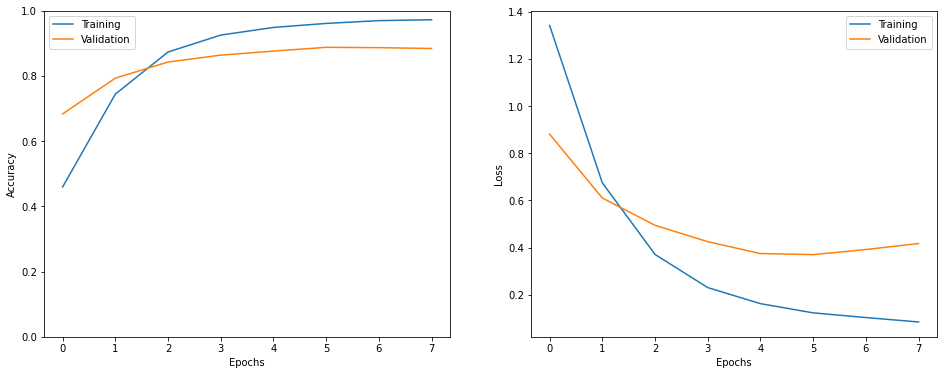

In [38]:
show_history(h)

### Performance on Test set

In [39]:
test_padded_seq, test_labels_class = prep_data(test)

In [40]:
_ = model.evaluate(test_padded_seq, test_labels_class)

63/63 [==============================] - 0s 5ms/step - loss: 0.4268 - accuracy: 0.8865


#### Checking one random example

In [41]:
# Checking particular instance:
i = random.randint(0, len(test)-1)

print('Tweet: ', test['text'][i])
print('Class: ', test['label'][i])

Tweet:  i feel dirty talking to people for my personal gain
Class:  sadness


In [42]:
# Fixing shape of input for model prediction
print( test_padded_seq[i].shape )
print( test_padded_seq[i] )

print( np.expand_dims(test_padded_seq[i], axis=0).shape )
print( np.expand_dims(test_padded_seq[i], axis=0) ) 

(50,)
[   2    3  627  532    5   63   16   11  868 1464    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
(1, 50)
[[   2    3  627  532    5   63   16   11  868 1464    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [43]:
model.predict(np.expand_dims(test_padded_seq[i], axis=0))

array([[8.8562578e-05, 2.9751101e-05, 3.8673505e-04, 1.3963949e-06,
        9.9779487e-01, 1.6987117e-03]], dtype=float32)

In [44]:
p = model.predict(np.expand_dims(test_padded_seq[i], axis=0))[0]

In [45]:
print('Prediction Class: ',index_to_class[p.argmax()])

Prediction Class:  sadness


#### Confusion Matrix

In [46]:
y_pred = model.predict(test_padded_seq)
y_class = [i.argmax() for i in y_pred]

In [47]:
confusion_matrix(test_labels_class, y_class)

array([[200,   0,   1,   3,   8,  12],
       [  5,  96,  41,   6,   2,   9],
       [  2,  23, 655,   3,   2,  10],
       [ 18,   4,   7,  35,   0,   2],
       [  3,   0,  18,   0, 531,  29],
       [  4,   1,   3,   1,  10, 256]], dtype=int64)

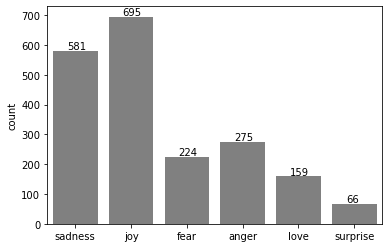

In [48]:
ax = sns.countplot(x=test['label'], color='grey')

for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+5))

In [49]:
class_to_index, class_to_index.keys()

({'fear': 0, 'love': 1, 'joy': 2, 'surprise': 3, 'sadness': 4, 'anger': 5},
 dict_keys(['fear', 'love', 'joy', 'surprise', 'sadness', 'anger']))

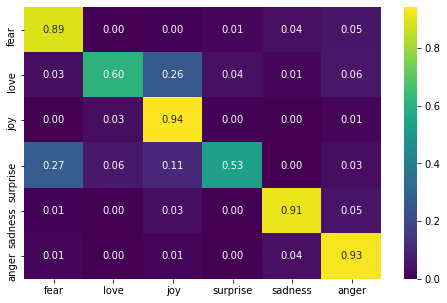

In [50]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(test_labels_class, y_class, normalize='true'), annot=True, fmt='.2f', cmap='viridis')
plt.xticks(ticks=np.array(range(6))+0.5, labels=class_to_index.keys())
plt.yticks(ticks=np.array(range(6))+0.5, labels=class_to_index.keys())
plt.show()

In [51]:
# The End